In [17]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from IPython.display import clear_output

clear_output()

In [18]:
CONFIG = {
    "model" : {"model_name" : "distilbert/distilbert-base-uncased", "tokenizer" : "distilbert/distilbert-base-uncased"}
}

# Prepare dataset

In [19]:
df = pd.read_csv("./data/train.csv")
df = df.rename(columns={"sentiment" : "label"})

mappings = {"positive" : 2, "neutral" : 1, "negative" : 0}

df["label"] = df["label"].map(mappings)

original_df = df

df = df.drop(['textID', 'selected_text'], axis=1)

In [20]:
def filter_text(text):
    # Remove words starting with "@"
    text = ' '.join(word for word in text.split() if not word.startswith('@'))
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    return text

# Apply the function to the "text" column
df["text"] = df["text"].apply(filter_text)


symbols = r'//'  # Add any symbols you want to match in the regex pattern

# Step 5: Filter the rows that contain the specified symbols
filtered_df = df[df['text'].str.contains(symbols, regex=True, na=False)]

filtered_df


,text,label
3889,i just looove my bf u are awesoome!!!! [hannah...,2
8657,// your FACE is stupid. thanks... i miss you t...,1
9056,"Oh, my God..... The end of the first course)))...",2
9823,is excited to be visited by her twin and best ...,2
12103,just got back from the Sing It Loud concert //...,2
13700,why did u copy wot i wrote //hmm,1
14992,Happy Star Wars Day // Will Week,2
16000,Listening to: Sweet Talk 101 - Cute Is What We...,0
17089,On the way to sthlm - it will maybe be a movie...,1
21415,Postponed is not abandoned. //,1


In [21]:
train_dataset_df, test_val_dataset_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_dataset_df, test_dataset_df = train_test_split(test_val_dataset_df, test_size=0.25, random_state=42, stratify=test_val_dataset_df["label"])

dataset = Dataset.from_pandas(df)
train_dataset = Dataset.from_pandas(train_dataset_df)
val_dataset = Dataset.from_pandas(val_dataset_df)
test_dataset = Dataset.from_pandas(test_dataset_df)
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 17312
})
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 5565
})
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 1855
})


# Data visualization

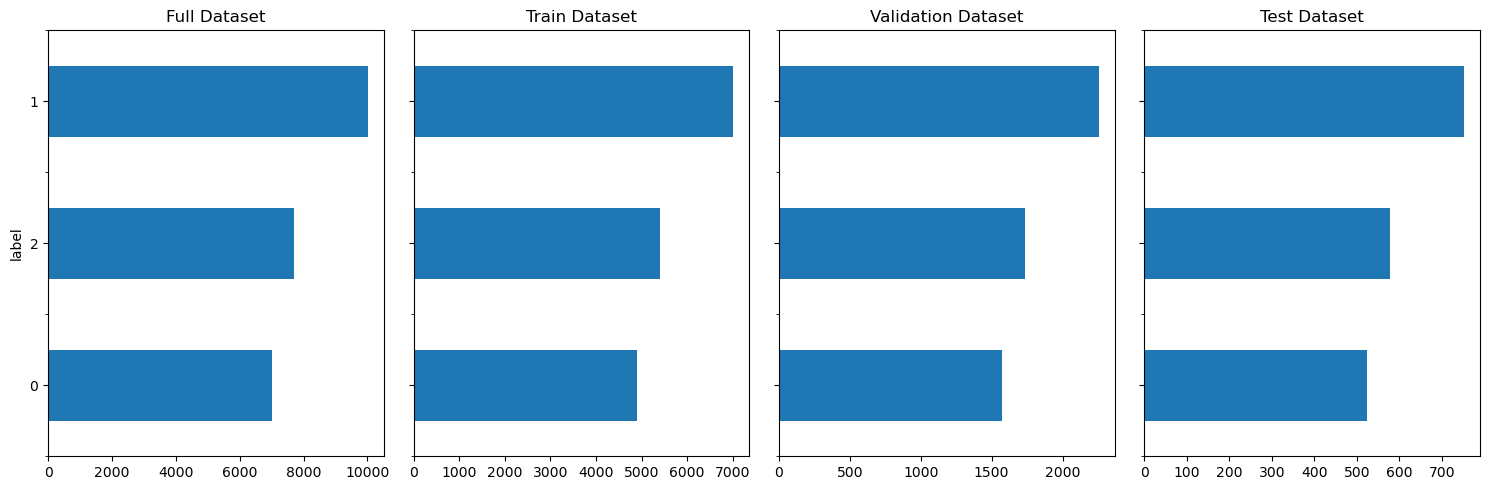

In [22]:
# Plot the value counts of label for each dataset
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)

df["label"].value_counts(ascending=True).plot.barh(ax=axes[0], title='Full Dataset')
train_dataset_df["label"].value_counts(ascending=True).plot.barh(ax=axes[1], title='Train Dataset')
val_dataset_df["label"].value_counts(ascending=True).plot.barh(ax=axes[2], title='Validation Dataset')
test_dataset_df["label"].value_counts(ascending=True).plot.barh(ax=axes[3], title='Test Dataset')

# Show the plots
plt.tight_layout()
plt.show()

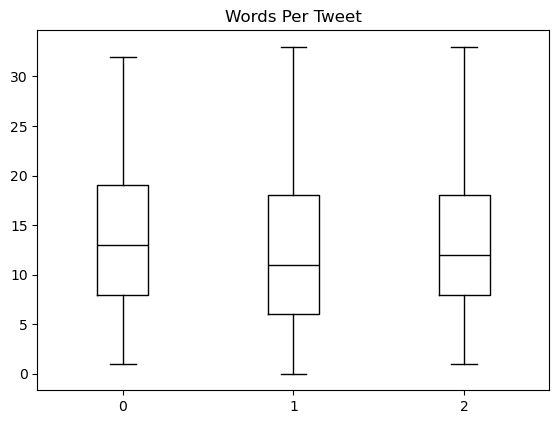

In [23]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()
df=df.drop(columns=["Words Per Tweet"],axis=1)

In [24]:
!pip install afinn

Defaulting to user installation because normal site-packages is not writeable
  Using cached afinn-0.1.tar.gz (52 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53429 sha256=54cd0eac211f87570cef0eaac3fb3efefc10e66abad03785ebf3f8c123a978df
  Stored in directory: /home/michele/.cache/pip/wheels/ee/d3/a0/f9255ebac29886acb1c28b35b37523f6399677fa06be379f25
Successfully built afinn


# Prepare model for training

In [25]:
from afinn import Afinn
from sklearn.metrics import accuracy_score

In [26]:
# Sentiment analysis with AFINN
afinn = Afinn(emoticons=True)
afinn_scores = [afinn.score(text) for text in df.text]
df['afinn'] = afinn_scores
df[['afinn', 'text']].head()
df['afinn_category'] = df['afinn'].apply(lambda score: 2 if score > 0 else (1 if score == 0 else 0))
accuracy = accuracy_score(df['label'], df['afinn_category'])
print(accuracy)

0.6477033802361313


In [27]:
def explain_afinn(text):
    words = text.split()
    word_scores = {word: afinn.score(word) for word in words}
    total_score = sum(word_scores.values())
    return word_scores, total_score
print(explain_afinn("this restaurant is not a shit, it might be okay for the dinner"))

({'this': 0.0, 'restaurant': 0.0, 'is': 0.0, 'not': 0.0, 'a': 0.0, 'shit,': -4.0, 'it': 0.0, 'might': 0.0, 'be': 0.0, 'okay': 0.0, 'for': 0.0, 'the': 0.0, 'dinner': 0.0}, -4.0)
